 #### Importing pandas and re

In [2]:
import pandas as pd
import re

#### Dataset Load and read 

In [4]:
df = pd.read_csv(r"C:\Users\ACER\Desktop\AML\AMLearning\AMLDATA.csv")

In [5]:
print("Shape of the dataset:", df.shape)
print("Columns contain in the dataset:", df.columns.tolist())
df.head()

Shape of the dataset: (50000, 2)
Columns contain in the dataset: ['review', 'sentiment']


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Basis check of the data counts missing values and duplications

In [7]:
print("\n Total Class counts of the dataset:\n", df["sentiment"].value_counts())
print("\nMissing values contain in the dataset:\n", df.isna().sum())
print("\nDuplicate rows appeared in the dataset:\n", df.duplicated().sum())


 Total Class counts of the dataset:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Missing values contain in the dataset:
 review       0
sentiment    0
dtype: int64

Duplicate rows appeared in the dataset:
 418


#### Cleaning dataset

In [9]:
df["sentiment"] = df["sentiment"].astype(str).str.lower().str.strip()

In [10]:
df = df[["review", "sentiment"]].dropna()
df = df.drop_duplicates()

In [11]:
print("\nAfter cleaning the shape of the dataset:\n", df.shape)
print("\nAfter cleaning the duplicate rows:\n",df.duplicated().sum())
print("\nUpdated class counts:\n",df["sentiment"].value_counts())
df.head()


After cleaning the shape of the dataset:
 (49582, 2)

After cleaning the duplicate rows:
 0

Updated class counts:
 sentiment
positive    24884
negative    24698
Name: count, dtype: int64


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### NLTK setup and download

In [13]:
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [15]:
HTML_RE = re.compile(r"<.*?>")
MULTISPACE_RE = re.compile(r"\s+")

stop_words = set(stopwords.words("english"))
negations = {"no", "nor", "not", "never", "n't"}  
stop_words = stop_words - negations

lemmatizer = WordNetLemmatizer()

def nltk_clean(text: str) -> str:
    text = str(text).lower()
    text = re.sub(HTML_RE, " ", text)
    text = re.sub(r"[^a-z\s']", " ", text)
    text = re.sub(MULTISPACE_RE, " ", text).strip()

    tokens = word_tokenize(text)

    clean_tokens = []
    for tok in tokens:
        if tok in stop_words:
            continue
        lemma = lemmatizer.lemmatize(tok)
        if len(lemma) > 1:
            clean_tokens.append(lemma)

    return " ".join(clean_tokens)


In [16]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [17]:
df["clean_review"] = df["review"].apply(nltk_clean)

In [18]:
df[["review", "clean_review", "sentiment"]].head()


,review,clean_review,sentiment
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode 'll...,positive
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...,positive
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,positive
3,Basically there's a family where a little boy ...,basically 's family little boy jake think 's z...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei 's love time money visually stun...,positive


In [19]:
df["sentiment"] = df["sentiment"].str.lower().str.strip()
df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})

df[["sentiment", "label"]].head()

,sentiment,label
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


In [20]:
from sklearn.model_selection import train_test_split

X = df["clean_review"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))
print("Train balance:\n", y_train.value_counts(normalize=True))
print("Test balance:\n", y_test.value_counts(normalize=True))


Train: 39665 Test: 9917
Train balance:
 label
1    0.501878
0    0.498122
Name: proportion, dtype: float64
Test balance:
 label
1    0.501865
0    0.498135
Name: proportion, dtype: float64


#### NB model

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nb_model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ("clf", MultinomialNB())
])

nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred, target_names=["negative", "positive"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, nb_pred))


Naive Bayes Accuracy: 0.8910960976101644
              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      4940
    positive       0.89      0.89      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917

Confusion Matrix:
 [[4411  529]
 [ 551 4426]]


#### Linear SVM

In [22]:
from sklearn.svm import LinearSVC

svm_model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ("clf", LinearSVC())
])

svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print("Linear SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred, target_names=["negative", "positive"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_pred))


Linear SVM Accuracy: 0.9088434002218413
              precision    recall  f1-score   support

    negative       0.92      0.90      0.91      4940
    positive       0.90      0.92      0.91      4977

    accuracy                           0.91      9917
   macro avg       0.91      0.91      0.91      9917
weighted avg       0.91      0.91      0.91      9917

Confusion Matrix:
 [[4442  498]
 [ 406 4571]]


#### ROC curve

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

In [24]:
nb_scores = nb_model.predict_proba(X_test)[:, 1]


In [25]:
svm_scores = svm_model.decision_function(X_test)

In [26]:
nb_fpr, nb_tpr, nb_thresh = roc_curve(y_test, nb_scores)
svm_fpr, svm_tpr, svm_thresh = roc_curve(y_test, svm_scores)

In [27]:
nb_auc = roc_auc_score(y_test, nb_scores)
svm_auc = roc_auc_score(y_test, svm_scores)


In [28]:
print("Naive Bayes AUC:", nb_auc)
print("Linear SVM AUC:", svm_auc)

Naive Bayes AUC: 0.955686685067098
Linear SVM AUC: 0.9705922140632334


In [29]:
import matplotlib.pyplot as plt

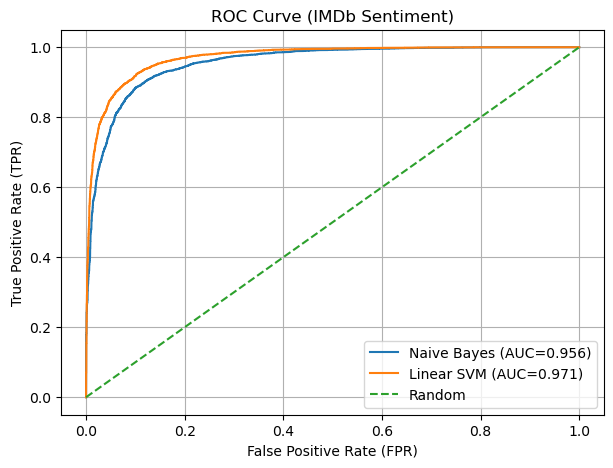

In [30]:
plt.figure(figsize=(7,5))
plt.plot(nb_fpr, nb_tpr, label=f"Naive Bayes (AUC={nb_auc:.3f})")
plt.plot(svm_fpr, svm_tpr, label=f"Linear SVM (AUC={svm_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve (IMDb Sentiment)")
plt.legend()
plt.grid(True)
plt.show()

#### Cross validation 

In [31]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [32]:
X=df["clean_review"]
y=df["label"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ("clf", MultinomialNB())
])

svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ("clf", LinearSVC())
])
nb_scores = cross_val_score(nb_pipe, X, y, cv=cv, scoring="accuracy")
svm_scores = cross_val_score(svm_pipe, X, y, cv=cv, scoring="accuracy")

print("NB accuracy per fold:", nb_scores)
print("NB mean accuracy:", nb_scores.mean())

print("\nSVM accuracy per fold:", svm_scores)
print("SVM mean accuracy:", svm_scores.mean())

NB accuracy per fold: [0.88847434 0.89200363 0.89310206 0.88533683 0.88715208]
NB mean accuracy: 0.8892137862451165

SVM accuracy per fold: [0.90581829 0.91257437 0.9124647  0.90722065 0.90974183]
SVM mean accuracy: 0.9095639694905392
